<a href="https://colab.research.google.com/github/Taghr66d/MSc-SummerProject2025/blob/main/Glitch_Samples_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install gengli


###Ref: ``gengli`` is a generating glitches package as shown by Lopez et al.(2022), *generative adversarial networks can simulate LIGO noise bursts effectively*.[https://doi.org/10.1103/PhysRevD.106.023027 arXiv:2203.06494].


In [ ]:
help(gengli.glitch_generator)

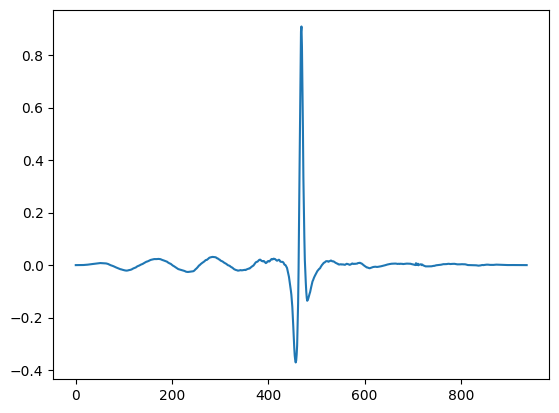

In [3]:
import gengli
import numpy as np
import matplotlib.pyplot as plt

g = gengli.glitch_generator('L1')
g_raw = g.get_glitch()

plt.plot(g_raw)


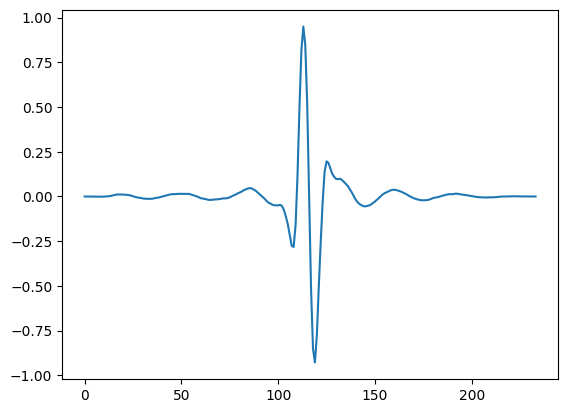

In [7]:
#Example (type = Blip)
blip= g.get_glitch(n_glitches=1, srate=1024.0, snr=None, glitch_type='Blip', seed=None, alpha=0.25, fhigh=None)
plt.plot(blip)

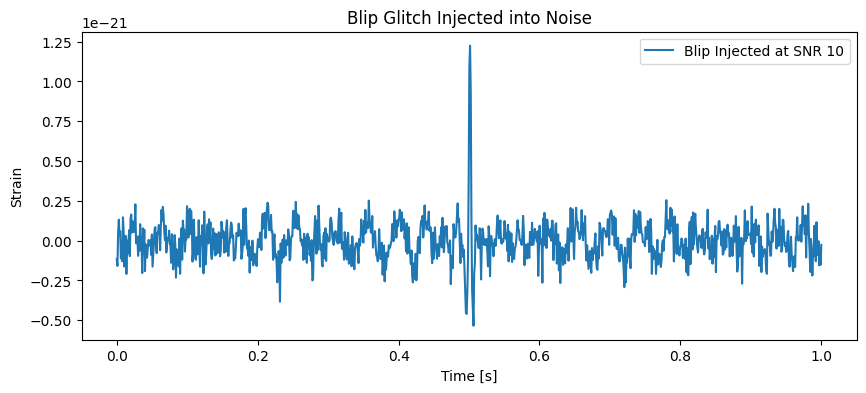

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, fftfreq
from scipy.interpolate import interp1d
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.noise import noise_from_psd


### configuration:
sample_rate = 1024
duration = 1.0
delta_t = 1.0 / sample_rate
n_samples = int(sample_rate * duration)
target_snr = 10
alpha = 0.25 #Tukey window factor

#### the same SNR of the cusp
def compute_standard_snr(signal, delta_t, psd, psd_freqs):
    N = len(signal)
    df = 1.0 / (N * delta_t)
    freqs = fftfreq(N, delta_t)
    signal_f = fft(signal)
    mask = freqs > 0
    freqs = freqs[mask]
    signal_f = signal_f[mask]
    psd_interp = interp1d(psd_freqs, psd, bounds_error=False, fill_value="extrapolate")
    psd_vals = np.maximum(psd_interp(freqs), 1e-40) #Avoid diveded by zero
    snr_squared = 4 * np.sum((np.abs(signal_f) ** 2) / psd_vals) * df
    return np.sqrt(snr_squared)


#### PSD as same the cusp scale
psd = aLIGOZeroDetHighPower(n_samples // 2 + 1, delta_f=1.0 / duration, low_freq_cutoff=20)
psd_freqs = np.linspace(0, sample_rate / 2, len(psd))
noise = noise_from_psd(n_samples, delta_t, psd, seed=42)

#### blip generator
blip_raw = np.squeeze(g.get_glitch(n_glitches=1, srate=sample_rate, glitch_type='Blip', alpha=alpha))

### scale
blip_current_snr = compute_standard_snr(blip_raw, delta_t, psd, psd_freqs)
blip_scaled = blip_raw * (target_snr / blip_current_snr)

strain = noise.copy()
start = (n_samples - len(blip_scaled)) // 2
strain[start:start + len(blip_scaled)] += blip_scaled

#### plot
t = np.linspace(0, duration, n_samples)
plt.figure(figsize=(10, 4))
plt.plot(t, strain, label=f'Blip Injected at SNR {target_snr}')
plt.xlabel("Time [s]")
plt.ylabel("Strain")
plt.title("Blip Glitch Injected into Noise")
plt.legend()
#plt.tight_layout()
plt.grid(False)

